In [1]:
import os
import itertools
import numpy as np
import numpy.random as npr
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi

Thu Dec  8 07:02:55 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
pip install --upgrade pip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.1 MB 4.8 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3


In [4]:
pip install "jax[cuda11_cudnn805]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


In [5]:
import jax.numpy as jnp
from jax.config import config
from jax import jit, grad, random
from jax.example_libraries import optimizers
from jax.example_libraries import stax
from jax.example_libraries.stax import Flatten, Dense, Relu, LogSoftmax

In [6]:
import tensorflow_datasets as tfds

In [7]:
def one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)

In [8]:
def loss(params, batch):
  inputs, targets = batch
  preds = predict(params, inputs)
  return -jnp.mean(jnp.sum(preds * targets, axis=1))


In [9]:
def batch_correctness(params, batch):
  inputs, targets = batch
  target_class = jnp.argmax(targets, axis=1)
  predicted_class = jnp.argmax(predict(params, inputs), axis=1)
  return predicted_class == target_class

In [10]:
def load_mnist():
  # NOTE: even when we specify shuffle_files=False, the examples 
  # in the MNIST dataset loaded by tfds is still NOT in the 
  # original MNIST data order
  raw_data = tfds.load(name='mnist', batch_size=-1,
                       as_dataset_kwargs={'shuffle_files': False})
  raw_data = tfds.as_numpy(raw_data)
  train_byte_images = raw_data['train']['image']
  train_images = train_byte_images.astype(np.float32) / 255
  train_int_labels = raw_data['train']['label']
  train_labels = one_hot(train_int_labels, 10)
  test_images = raw_data['test']['image'].astype(np.float32) / 255
  test_labels = one_hot(raw_data['test']['label'], 10)
  return dict(train_images=train_images, train_labels=train_labels,
              train_byte_images=train_byte_images, 
              train_int_labels=train_int_labels,
              test_images=test_images, test_labels=test_labels,
              test_byte_images=raw_data['test']['image'],
              test_int_labels=raw_data['test']['label'])


In [ ]:
import cv2
from google.colab.patches import cv2_imshow
a = load_mnist()

In [ ]:
for i in range(a['train_images'].shape[0]):
  print(i)

In [ ]:
gauss_noise = np.zeros((28, 28), dtype=np.float32)
cv2.randn(gauss_noise, 0, 1)
gauss_noise = (gauss_noise*0.5).astype(np.float32)

for itr in len(train_images.shape[0]:
  train_images[itr][:,:,0] = cv2.add(train_images[itr][:,:,0]*255, gauss_noise)/255

In [ ]:
gauss_noise = np.zeros((28, 28), dtype=np.float32)
cv2.randn(gauss_noise, 0, 1)
gauss_noise = (gauss_noise*0.5).astype(np.float32)

temp = cv2.add(a['train_images'][0][:,:,0]*255, gauss_noise)
cv2_imshow(temp)

In [ ]:
temp

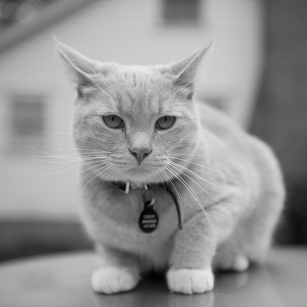

(307, 307)


In [ ]:
img = cv2.imread("temp.jpg", 0)
scale_percent = 10 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
  
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

cv2_imshow(resized)
print(resized.shape)

In [ ]:
gauss_noise = np.zeros((307, 307), dtype=np.uint8)
cv2.randn(gauss_noise, 128, 20)
gauss_noise = (gauss_noise*0.5).astype(np.uint8)

In [ ]:
#temp = cv2.add(a['train_images'][0][:,:,0]*255, gauss_noise)
temp = cv2.add(resized, gauss_noise)

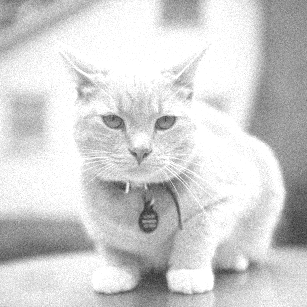

In [ ]:
cv2_imshow(temp)

In [11]:
init_random_params, predict = stax.serial(
    Flatten,
    Dense(512), Relu,
    Dense(256), Relu,
    Dense(10), LogSoftmax)
mnist_data = load_mnist()

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [12]:
def subset_train(seed, subset_ratio):
  jrng = random.PRNGKey(seed)
  
  step_size = 0.1
  num_epochs = 10
  batch_size = 128
  momentum_mass = 0.9

  num_train_total = mnist_data['train_images'].shape[0]
  num_train = int(num_train_total * subset_ratio)
  num_batches = int(np.ceil(num_train / batch_size))

  rng = npr.RandomState(seed)
  subset_idx = rng.choice(num_train_total, size=num_train, replace=False)
  train_images = mnist_data['train_images'][subset_idx]
  train_labels = mnist_data['train_labels'][subset_idx]

  def data_stream(shuffle=True):
    while True:
      perm = rng.permutation(num_train)
      for i in range(num_batches):
        batch_idx = perm[i * batch_size:(i + 1) * batch_size]
        yield train_images[batch_idx], train_labels[batch_idx]

  batches = data_stream()

  opt_init, opt_update, get_params = optimizers.momentum(step_size, mass=momentum_mass)

  @jit
  def update(i, opt_state, batch):
    params = get_params(opt_state)
    return opt_update(i, grad(loss)(params, batch), opt_state)

  _, init_params = init_random_params(jrng, (-1, 28 * 28))
  opt_state = opt_init(init_params)
  itercount = itertools.count()

  for epoch in range(num_epochs):
    for _ in range(num_batches):
      opt_state = update(next(itercount), opt_state, next(batches))

  params = get_params(opt_state)
  trainset_correctness = batch_correctness(
      params, (mnist_data['train_images'], mnist_data['train_labels']))
  testset_correctness = batch_correctness(
      params, (mnist_data['test_images'], mnist_data['test_labels']))

  trainset_mask = np.zeros(num_train_total, dtype=np.bool)
  trainset_mask[subset_idx] = True
  return trainset_mask, np.asarray(trainset_correctness), np.asarray(testset_correctness)

In [13]:
def estimate_infl_mem():
  n_runs = 10
  subset_ratio = 0.7
  
  results = []
  for i_run in tqdm(range(n_runs), desc=f'SS Ratio={subset_ratio:.2f}'):
    results.append(subset_train(i_run, subset_ratio))

  trainset_mask = np.vstack([ret[0] for ret in results])
  inv_mask = np.logical_not(trainset_mask)
  trainset_correctness = np.vstack([ret[1] for ret in results])
  testset_correctness = np.vstack([ret[2] for ret in results])

  print(f'Avg test acc = {np.mean(testset_correctness):.4f}')

  def _masked_avg(x, mask, axis=0, esp=1e-10):
    return (np.sum(x * mask, axis=axis) / np.maximum(np.sum(mask, axis=axis), esp)).astype(np.float32)

  def _masked_dot(x, mask, esp=1e-10):
    x = x.T.astype(np.float32)
    return (np.matmul(x, mask) / np.maximum(np.sum(mask, axis=0, keepdims=True), esp)).astype(np.float32)

  mem_est = _masked_avg(trainset_correctness, trainset_mask) - _masked_avg(trainset_correctness, inv_mask)
  infl_est = _masked_dot(testset_correctness, trainset_mask) - _masked_dot(testset_correctness, inv_mask)

  return dict(memorization=mem_est, influence=infl_est)

In [14]:
def show_examples(estimates, n_show=10):
  def show_image(ax, image, vmin=None, vmax=None, title=None):
    if image.ndim == 3 and image.shape[2] == 1:
      image = image.reshape((image.shape[0], image.shape[1]))
    ax.axis('off')
    ax.imshow(image, cmap='gray', vmin=vmin, vmax=vmax)
    if title is not None:
      ax.set_title(title, fontsize='x-small')

  n_show = 10
  n_context1 = 4
  n_context2 = 5

  fig, axs = plt.subplots(nrows=n_show, ncols=n_context1+n_context2+1,
                          figsize=(n_context1+n_context2+1, n_show))
  idx_sorted = np.argsort(np.max(estimates['influence'], axis=1))[::-1]
  for i in range(n_show):
    # show test example
    idx_tt = idx_sorted[i]
    label_tt = mnist_data['test_int_labels'][idx_tt]
    show_image(axs[i, 0], mnist_data['test_byte_images'][idx_tt], 
               title=f'test,L={label_tt}')

    def _show_contexts(idx_list, ax_offset):
      for j, idx_tr in enumerate(idx_list):
        label_tr = mnist_data['train_int_labels'][idx_tr]
        infl = estimates['influence'][idx_tt, idx_tr]
        show_image(axs[i, j+ax_offset], mnist_data['train_byte_images'][idx_tr],
                   title=f'tr,L={label_tr},infl={infl:.3f}')

    # show training examples with highest influence
    idx_sorted_tr = np.argsort(estimates['influence'][idx_tt])[::-1]
    _show_contexts(idx_sorted_tr[:n_context1], 1)

    # show random training examples from the same class
    idx_class = np.nonzero(mnist_data['train_int_labels'] == label_tt)[0]
    idx_random = np.random.choice(idx_class, size=n_context2, replace=False)
    _show_contexts(idx_random, n_context1 + 1)

  plt.tight_layout()
  plt.savefig('mnist-examples.pdf', bbox_inches='tight')
  

SS Ratio=0.70:   0%|          | 0/10 [00:00<?, ?it/s]<ipython-input-12-209444b6581c>:48: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  trainset_mask = np.zeros(num_train_total, dtype=np.bool)
SS Ratio=0.70: 100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


Avg test acc = 0.9801


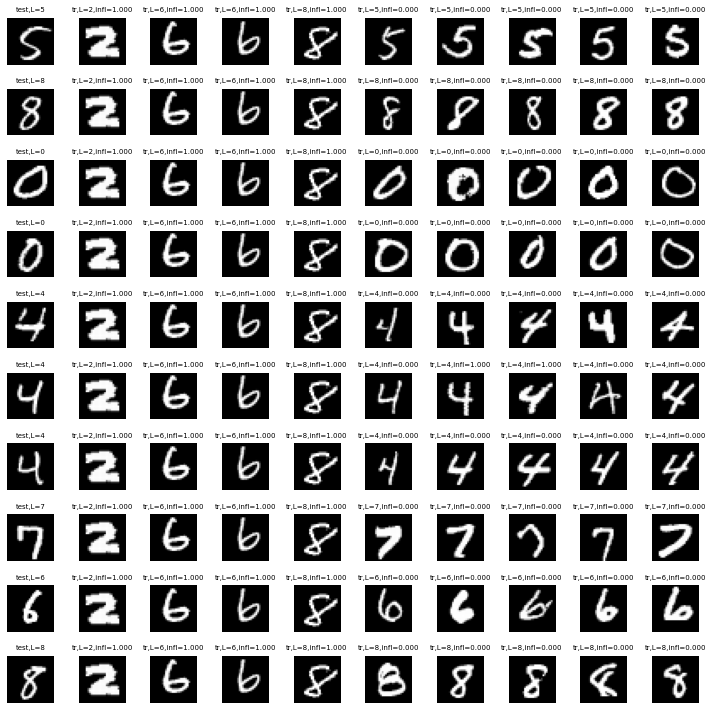

In [15]:
if __name__ == '__main__':
  npz_fn = 'infl_mem.npz'
  if os.path.exists(npz_fn):
    estimates = np.load(npz_fn)
  else:
    estimates = estimate_infl_mem()
    np.savez(npz_fn, **estimates)

  show_examples(estimates)